In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

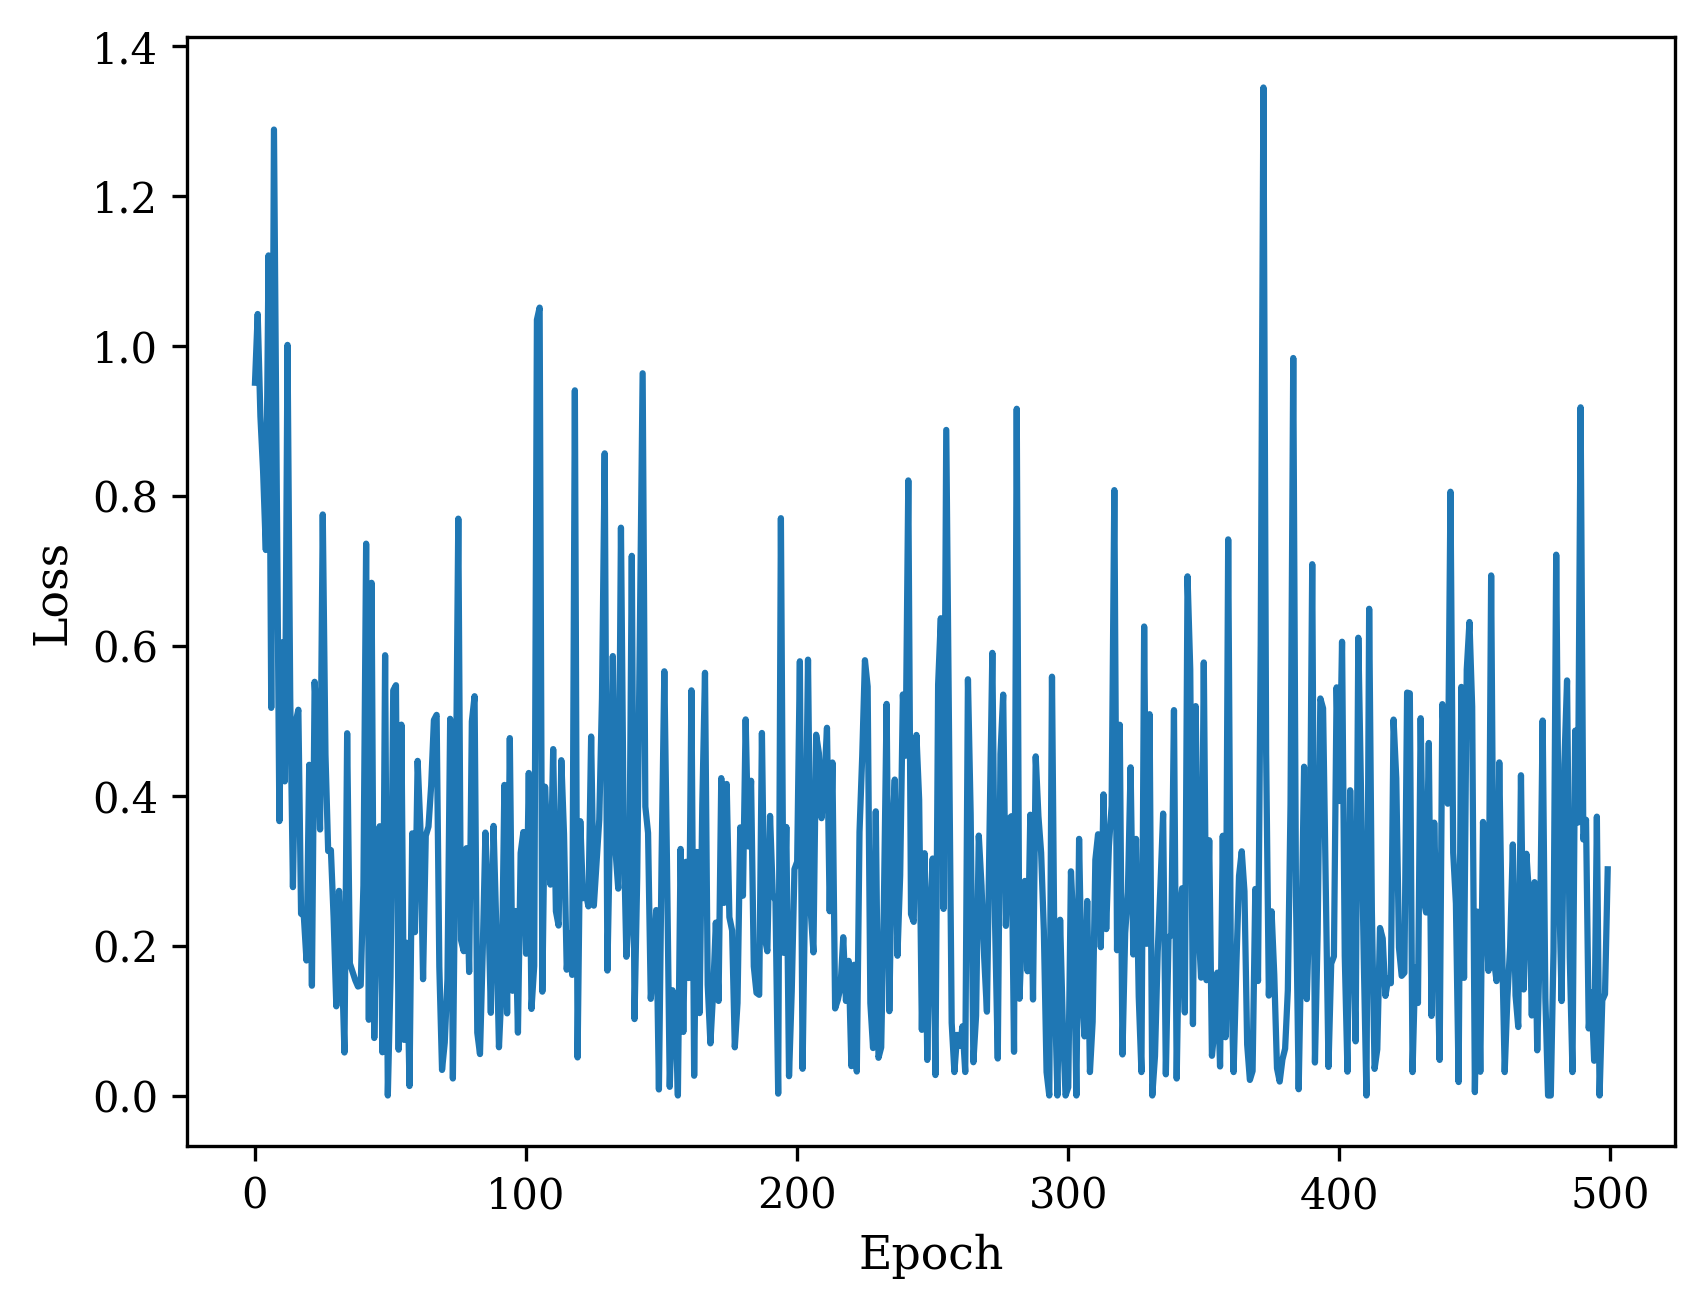

In [14]:
# BYOL for learning robot idx embeddings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim) 

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

def get_neighbors(index, grid_size=8):
    row, col = index // grid_size, index % grid_size
    neighbors = []
    if row > 0:  # Up
        neighbors.append((row - 1) * grid_size + col)
    if row < grid_size - 1:  # Down
        neighbors.append((row + 1) * grid_size + col)
    if col > 0:  # Left
        neighbors.append(row * grid_size + col - 1)
    if col < grid_size - 1:  # Right
        neighbors.append(row * grid_size + col + 1)
    return np.array(neighbors)

def select_random_neighbors(batch_indices, neighbors):
    batch_size = len(batch_indices)
    random_neighbors = np.zeros(batch_size, dtype=int)
    for i in range(batch_size):
        neighbor_list = neighbors[batch_indices[i]]
        random_neighbors[i] = np.random.choice(neighbor_list)
    return random_neighbors

indices = np.arange(64)
neighbors = np.array([get_neighbors(i) for i in indices], dtype=object)
# print(neighbors)
# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 256  # Size of the embedding vector
batch_size = 32

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 500
grid_size = 8
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    idxs = np.random.randint(0, num_embeddings, (batch_size,))

    indices = torch.tensor(idxs).to(device)  # Batch size of 32
    embedding1 = model(indices)

    random_neighbors = torch.tensor(select_random_neighbors(idxs, neighbors)).to(device)
    embedding2 = model(random_neighbors)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,)).to(device)) % num_embeddings  # Ensure it wraps around at the max integer
    embedding3 = model(indices_2.to(device))

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding2, embedding3)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
# load toech model
# model.load_state_dict(torch.load('idx_embedding_128.pth', weights_only=True))

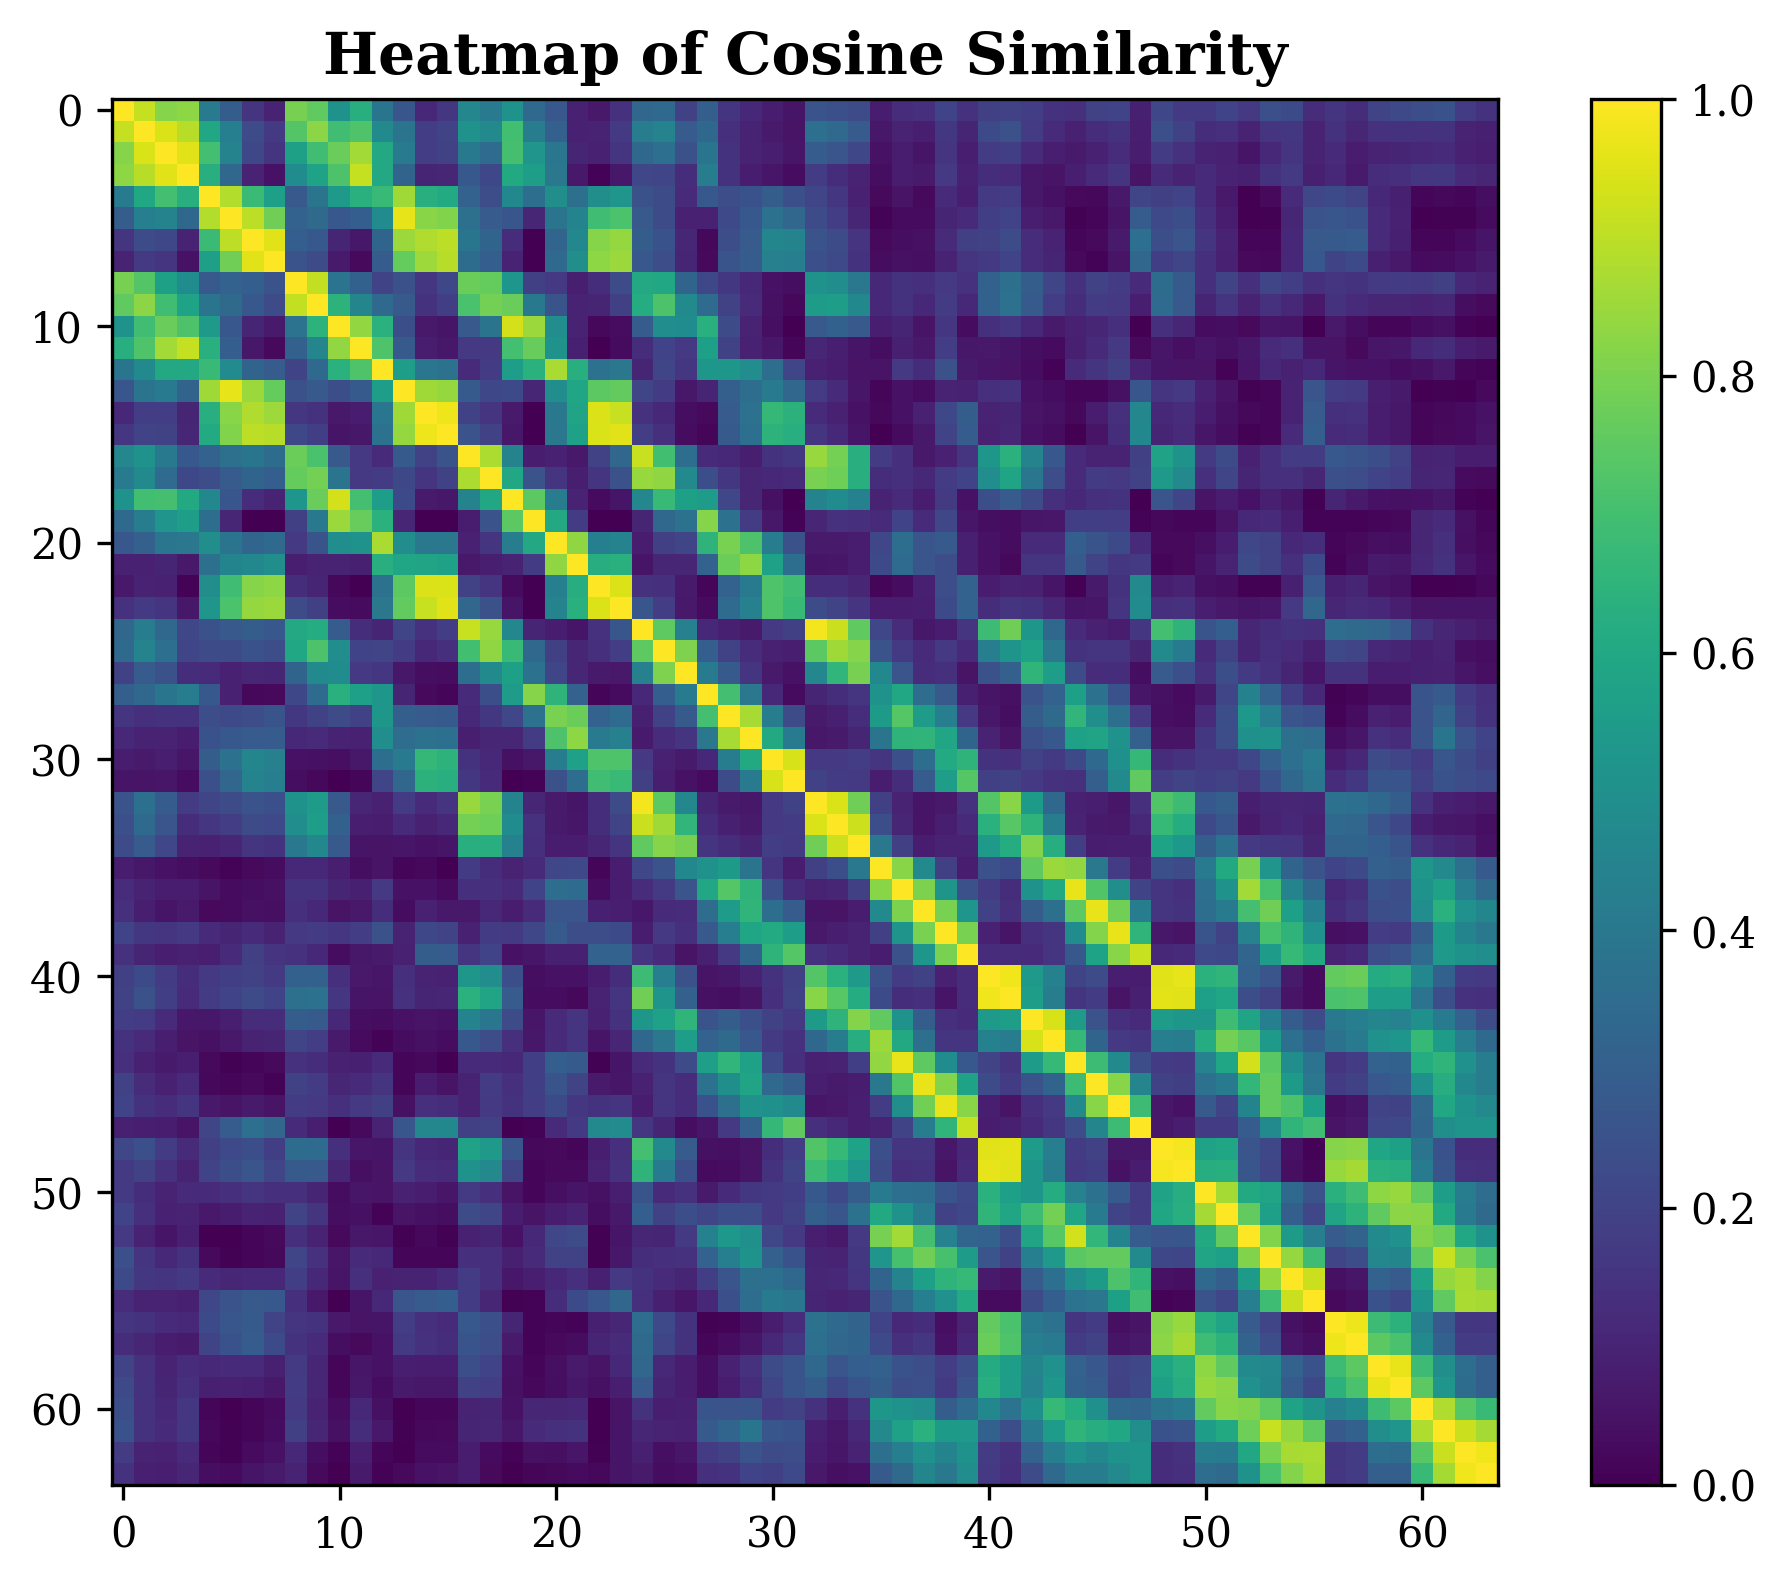

In [16]:
n_values = torch.arange(64).to(device)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [9]:
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

from sklearn.metrics.pairwise import cosine_similarity
# Generate embeddings
embed1 = generate_sinusoidal_embeddings(64, 128)
embed2 = a.detach().cpu().numpy()
embed2 = embed2 / np.linalg.norm(embed2, axis=1, keepdims=True)
embed1 = torch.tensor(embed1)
embed2 = torch.tensor(embed2)
cos_sim_matrix1 = torch.zeros(64, 64)
cos_sim_matrix2 = torch.zeros(64, 64)
for i in range(64):
    for j in range(64):
        cos_sim_matrix1[i, j] = cos_sim(embed1[i], embed1[j])
        cos_sim_matrix2[i, j] = cos_sim(embed2[i], embed2[j])

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# plt.imshow(embed1, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.imshow(embed2, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()

import seaborn as sns

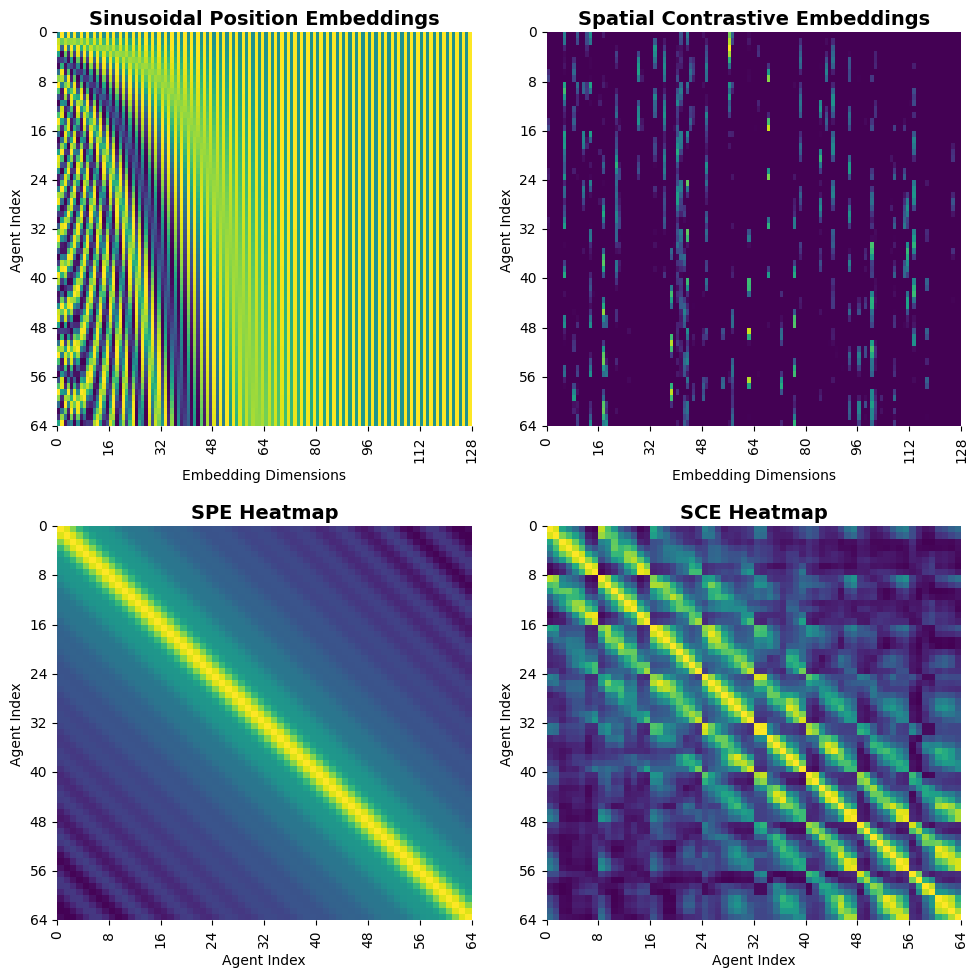

In [10]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
font = {'size': 14}
plt.rc('font', **font)
plt.rc('axes', titlesize=font['size'])
plt.rc('legend', fontsize=10)
plt.rc('figure', dpi=300)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(embed1, ax=axes[0, 0], cmap="viridis", cbar=False)
axes[0, 0].set_title('Sinusoidal Position Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
axes[0, 0].set_yticks(np.arange(0, 65, 8))
axes[0, 0].set_yticklabels(np.arange(0, 65, 8))
axes[0, 0].set_xticks(np.arange(0, 129, 16))
axes[0, 0].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(embed2, ax=axes[0, 1], cmap="viridis", cbar=False)
axes[0, 1].set_title('Spatial Contrastive Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
axes[0, 1].set_yticks(np.arange(0, 65, 8))
axes[0, 1].set_yticklabels(np.arange(0, 65, 8))
axes[0, 1].set_xticks(np.arange(0, 129, 16))
axes[0, 1].set_xticklabels(np.arange(0, 129, 16))

sns.heatmap(cos_sim_matrix1, ax=axes[1, 0], cmap="viridis", cbar=False)
axes[1, 0].set_title('SPE Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
axes[1, 0].set_yticks(np.arange(0, 65, 8))
axes[1, 0].set_yticklabels(np.arange(0, 65, 8))
axes[1, 0].set_xticks(np.arange(0, 65, 8))
axes[1, 0].set_xticklabels(np.arange(0, 65, 8))

sns.heatmap(cos_sim_matrix2, ax=axes[1, 1], cmap="viridis", cbar=False)
axes[1, 1].set_title('SCE Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
axes[1, 1].set_yticks(np.arange(0, 65, 8))
axes[1, 1].set_yticklabels(np.arange(0, 65, 8))
axes[1, 1].set_xticks(np.arange(0, 65, 8))
axes[1, 1].set_xticklabels(np.arange(0, 65, 8))

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of seaborn color maps
cmaps = [
    'viridis', 'plasma', 'inferno', 'magma', 'cividis', 
    'rocket', 'mako', 'flare', 'crest'
]

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot each color map
fig, axes = plt.subplots(nrows=len(cmaps), figsize=(8, 20))
for ax, cmap in zip(axes, cmaps):
    ax.imshow(gradient, aspect='auto', cmap=sns.color_palette(cmap, as_cmap=True))
    ax.set_title(cmap, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [56]:
# torch.save(model.state_dict(), 'idx_embedding_128.pth')